In [1]:
import requests
from bs4 import BeautifulSoup
import pandas as pd
import time
import random
from tqdm import tqdm
import matplotlib.pyplot as plt


# Config
TRENDING_URL = "https://github.com/trending"
OUTPUT_DIR = "output"
USER_AGENTS = [
"Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/120.0.0.0 Safari/537.36",
"Mozilla/5.0 (Macintosh; Intel Mac OS X 10_15_7) AppleWebKit/605.1.15 (KHTML, like Gecko) Version/16.4 Safari/605.1.15",
]


import os
os.makedirs(OUTPUT_DIR, exist_ok=True)


plt.rcParams['figure.figsize'] = (10,6)

In [9]:
# Helper
def get_soup(url, timeout=10):
    headers = {
        "User-Agent": random.choice(USER_AGENTS),
        "Accept-Language": "en-US,en;q=0.9"
    }
    response = requests.get(url, headers=headers, timeout=timeout)
    response.raise_for_status()
    return BeautifulSoup(response.text, "html.parser")


def parse_repo_item(item):
    header = item.find("h1", class_="h3")
    if header:
        repo_link = header.find("a")
        repo_name = repo_link.get_text(strip=True).replace("\n", "").replace(" ", "")
        repo_url = "https://github.com" + repo_link["href"]
    else:
        repo_name = None
        repo_url = None

    desc_tag = item.find("p", class_="col-9")
    description = desc_tag.get_text(strip=True) if desc_tag else None

    lang_tag = item.find("span", itemprop="programmingLanguage")
    language = lang_tag.get_text(strip=True) if lang_tag else None

    star_tag = item.find("a", href=lambda x: x and x.endswith("/stargazers"))
    stars = None
    if star_tag:
        try:
            stars_text = star_tag.get_text(strip=True).replace(",", "")
            if "k" in stars_text.lower():
                stars = int(float(stars_text.lower().replace("k", "")) * 1000)
            else:
                stars = int(stars_text)
        except:
            stars = None

    return {
        "name": repo_name,
        "url": repo_url,
        "description": description,
        "language": language,
        "stars": stars
    }


In [10]:
# Scraper
def scrape_trending(url=TRENDING_URL):
    soup = get_soup(url)
    repo_list = soup.find_all("article", class_="Box-row")

    results = []
    for item in repo_list:
        parsed = parse_repo_item(item)
        results.append(parsed)
        time.sleep(random.uniform(0.3, 0.7))  

    return results


Scraping GitHub Trending...

Saved: output\trending.csv
Saved: output\trending.json

Top 10 by stars:

    name   stars    language
10  None  133565  TypeScript
14  None  101624  TypeScript
4   None   89417       Shell
5   None   58582          Go
2   None   57313        Roff
3   None   42536      Python
15  None   41536      Python
16  None   39402          Go
6   None   23590      Python
0   None   18818      Python


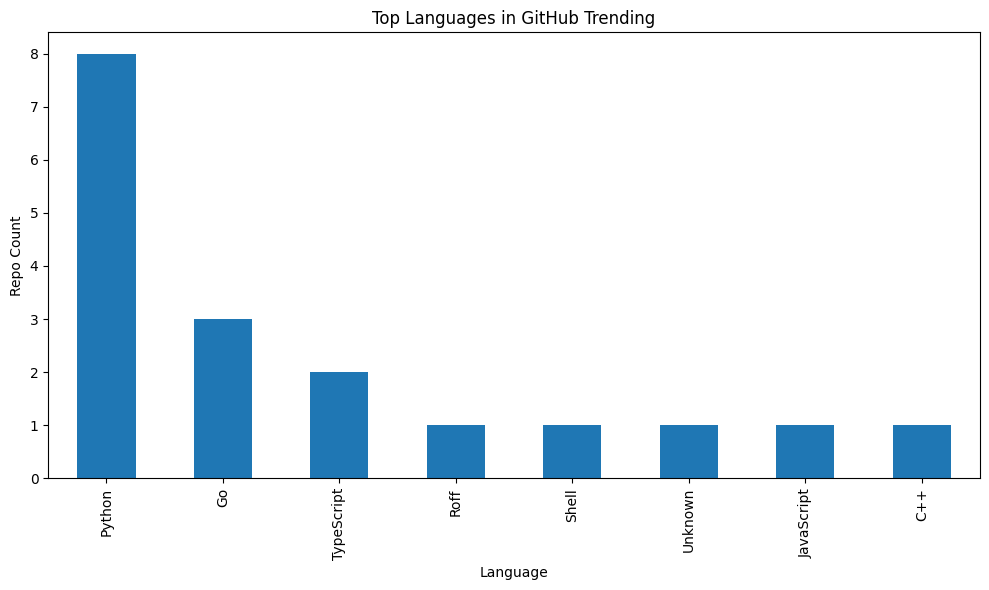

In [11]:
# Main
def main():
    print("Scraping GitHub Trending...")
    results = scrape_trending()
    df = pd.DataFrame(results)

    # Cleaning
    df["stars"] = df["stars"].fillna(0).astype(int)
    df["language"] = df["language"].fillna("Unknown")

    # Save
    csv_path = os.path.join(OUTPUT_DIR, "trending.csv")
    json_path = os.path.join(OUTPUT_DIR, "trending.json")

    df.to_csv(csv_path, index=False)
    df.to_json(json_path, orient="records", indent=2)

    print("\nSaved:", csv_path)
    print("Saved:", json_path)

    print("\nTop 10 by stars:\n")
    print(df.sort_values("stars", ascending=False).head(10)[["name", "stars", "language"]])

    # Visualization
    lang_counts = df["language"].value_counts().head(10)
    lang_counts.plot(kind="bar")
    plt.title("Top Languages in GitHub Trending")
    plt.xlabel("Language")
    plt.ylabel("Repo Count")
    plt.tight_layout()
    plt.show()


if __name__ == "__main__":
    main()
